# Siamese One-Shot-Learning Network, [Fruits 360](https://www.kaggle.com/moltean/fruits) Using [ReNom](https://www.renom.jp/)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from PIL import Image, ImageOps
import random

In [2]:
import renom as rm
from renom.optimizer import Adam

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Set Configs

In [4]:
TRAIN_DIR = './datasets/fruits/training/'
TEST_DIR = './datasets/fruits/testing/'
BATCH_SIZE = 64
N_EPOCHS = 20
LR = 0.0005
N_GPU = 1
SET_L = True
INPUT_D = 3 if SET_L == False else 1

## Set Helpers

In [5]:
def show_img(img, text=None, figsize=(20,20), should_save=False):
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(50, 8, text, bbox={'facecolor': 'white', 'alpha': 1 })
    
    plt.imshow(img, cmap='gray')
    plt.show()

## Configure Custom Data Generator

In [6]:
class SiameseDataGenerator(object):

    def __init__(self, datasets, transform=None, shuffle=True, batch_size=64, 
                 should_invert=True, set_luminance=True):
        self.datasets = datasets
        self.transform = transform
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.should_invert = should_invert
        self.set_luminance = set_luminance
        
    def __getitem__(self, index):
        
        imageA_data = []
        imageB_data = []
        label_data = []

        while True:
            
            if self.shuffle: random.shuffle(datasets)
            for imageA_tupple in [data for data in datasets]:
                
                get_same_class = random.randint(0,1)
                if get_same_class:
                    while True:
                        imageB_tupple = random.choice(self.datasets)
                        if imageA_tupple[1] == imageB_tupple[1]:
                            break
                else:
                    while True:
                        imageB_tupple = random.choice(self.datasets)
                        if imageA_tupple[1] != imageB_tupple[1]:
                            break
                            
                imageA = Image.open(imageA_tupple[0])
                imageB = Image.open(imageB_tupple[0])
                
                if self.set_luminance:
                    imageA = imageA.convert('L')
                    imageB = imageB.convert('L')
                
                if self.should_invert:
                    imageA = ImageOps.invert(imageA)
                    imageB = ImageOps.invert(imageB)

                if self.transform is not False:
                    imageA = imageA.resize((100, 100), resample=Image.BILINEAR)
                    imageB = imageB.resize((100, 100), resample=Image.BILINEAR)
            
                    imageA = np.array(imageA)
                    imageB = np.array(imageB)
                    
                    imageA = np.expand_dims(imageA, axis=0)
                    imageB = np.expand_dims(imageB, axis=0)
                    
                    imageA = imageA/ 255.
                    imageB = imageB/ 255.
                
                imageA_data.append(imageA)
                imageB_data.append(imageB)
                label_data.append(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
                
                if len(imageA_data) == self.batch_size:
                    imageA_batch = np.array(imageA_data)
                    imageB_batch = np.array(imageB_data)
                    label_batch = np.array(label_data)
                    imageA_data = []
                    imageB_data = []
                    label_data = []
                
                    yield imageA_batch, imageB_batch, label_batch
    
    def __len__(self):
        return len(self.datasets)

In [7]:
def load_datasets(path_dir):
    datasets = list()
    train_list = [data for data in os.listdir(path_dir) if data != 'README']
    for idx_train, train in enumerate(train_list):
        image_list = os.listdir(path_dir + train)
        for image in image_list:
            datasets.append((path_dir + train + '/' + image, idx_train))
    
    return datasets

## Prepare Training Data

In [8]:
datasets = load_datasets(path_dir=TRAIN_DIR)
siamese_generator = SiameseDataGenerator(datasets=datasets, transform=True, shuffle=True,
                                         batch_size=BATCH_SIZE, should_invert=False, set_luminance=SET_L)

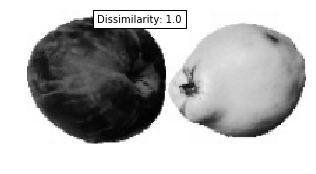

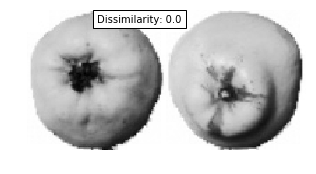

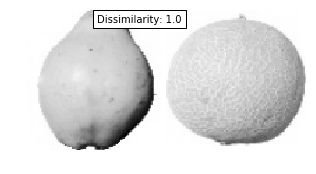

In [9]:
for _ in range(3):
    imageA, imageB, label = siamese_generator.__getitem__(True).__next__()
    
    stacked_image = np.hstack((imageA[0][0], imageB[0][0]))
    show_img(stacked_image, text="Dissimilarity: {}".format(label[0][0]), figsize=(5,5))

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture

In [10]:
class SiameseNet(rm.Model):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv_layer = rm.Sequential([
            rm.Conv2d(channel=4, filter=3, padding=1),
            rm.Relu(),
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
        ])
        
        self.fc_layer = rm.Sequential([
            rm.Flatten(),
            rm.Dense(500),
            rm.Relu(),
            rm.Dense(500),
            rm.Relu(),
            rm.Dense(5),
        ])
        
    def forward_once(self, x, attr):
        x = self.conv_layer(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA, attr='A')
        resultB = self.forward_once(imageB, attr='B')
        
        return resultA, resultB

#### Initialize Siamese Network

In [11]:
siamese = SiameseNet()

## Loss Function

In [12]:
class ContrastiveLoss(rm.Model):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, resultA, resultB, label):
        euclidean_distance = pairwise.euclidean_distances(resultA, resultB)
        contrastive_loss = rm.mean((1-label) * rm.square(euclidean_distance) +
                                   (label) * rm.square(np.clip(self.margin - euclidean_distance, a_min=0.0, a_max=(self.margin - euclidean_distance).max())))
        
        return contrastive_loss

In [13]:
contrastive_loss = ContrastiveLoss()

## Set Optimizer

In [14]:
optimizer = rm.Adam(lr=LR)

## Train The Network

In [15]:
train_loss = 0
train_loss_history = []
N = len(datasets)

for epoch in range(N_EPOCHS):
    
    train_generator = siamese_generator.__getitem__(True)
    for batch_idx in range(N//BATCH_SIZE):
        
        imageA, imageB, label = train_generator.__next__()
        with siamese.train():
            resultA, resultB = siamese(imageA, imageB)
            loss = contrastive_loss(resultA, resultB, label)
            
        loss.grad().update(optimizer)
    
    train_loss = train_loss/(N//BATCH_SIZE)
    train_loss_history.append(train_loss)
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, train_loss))

Train Epoch: 1 Loss: 0.000000
Train Epoch: 2 Loss: 0.000000
Train Epoch: 3 Loss: 0.000000
Train Epoch: 4 Loss: 0.000000
Train Epoch: 5 Loss: 0.000000
Train Epoch: 6 Loss: 0.000000
Train Epoch: 7 Loss: 0.000000
Train Epoch: 8 Loss: 0.000000
Train Epoch: 9 Loss: 0.000000
Train Epoch: 10 Loss: 0.000000
Train Epoch: 11 Loss: 0.000000
Train Epoch: 12 Loss: 0.000000
Train Epoch: 13 Loss: 0.000000
Train Epoch: 14 Loss: 0.000000
Train Epoch: 15 Loss: 0.000000
Train Epoch: 17 Loss: 0.000000
Train Epoch: 18 Loss: 0.000000
Train Epoch: 19 Loss: 0.000000
Train Epoch: 20 Loss: 0.000000


## Evaluate The Network

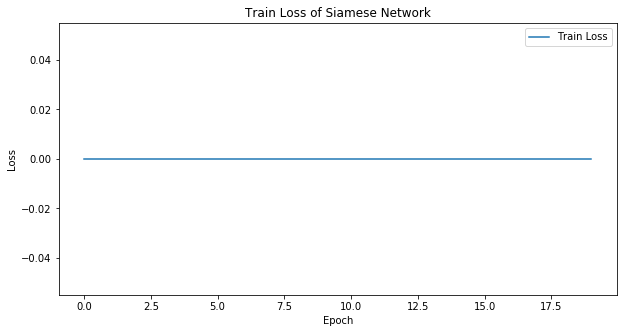

In [16]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Siamese Network")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/fruits/'): os.makedirs('./images/fruits/')
plt.show()

In [17]:
datasets = load_datasets(path_dir=TEST_DIR)
siamese_generator = SiameseDataGenerator(datasets=datasets, transform=True, shuffle=True,
                                         batch_size=1, should_invert=False)

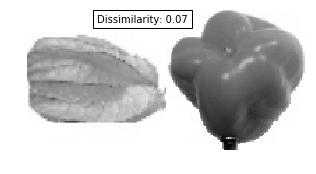

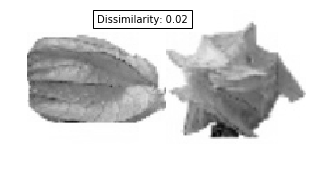

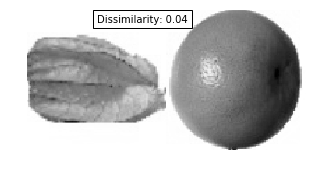

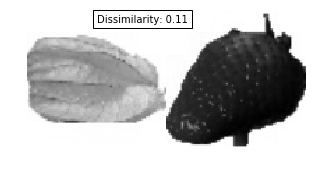

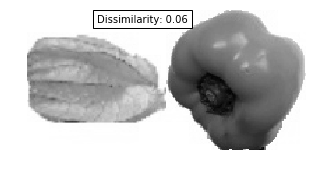

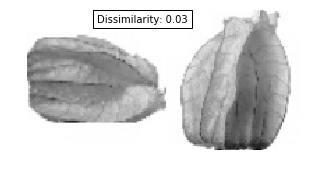

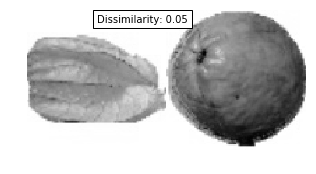

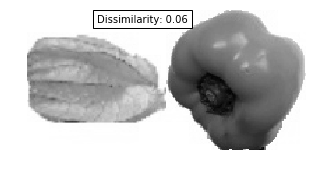

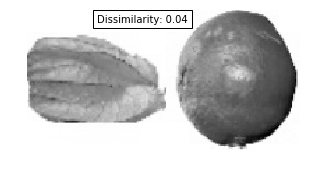

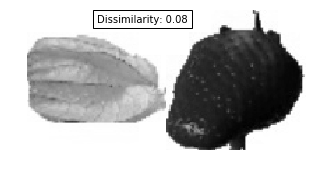

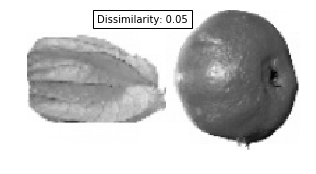

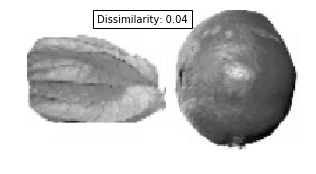

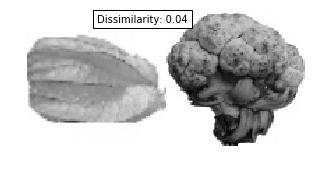

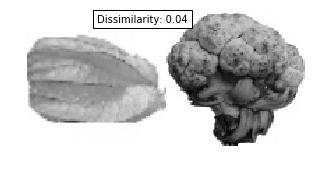

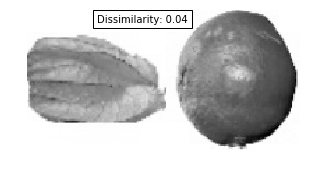

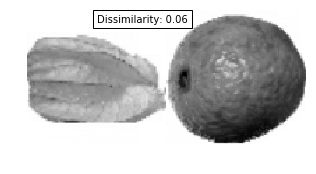

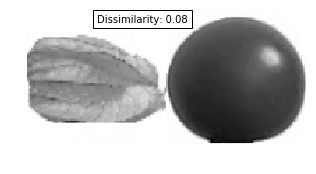

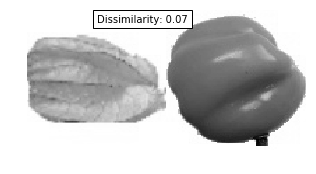

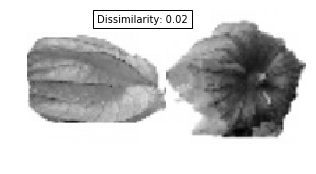

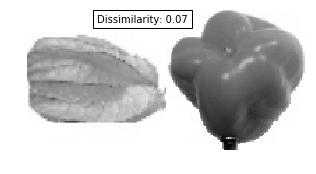

In [18]:
test_generator = siamese_generator.__getitem__(True)
imageA, _, _ = test_generator.__next__()
for i in range(20):
    _, imageB, label = test_generator.__next__()
    resultA, resultB = siamese(imageA, imageB)
    euclidean_distance = pairwise.euclidean_distances(resultA, resultB)

    stacked_image = np.hstack((imageA[0][0], imageB[0][0]))
    show_img(stacked_image, 'Dissimilarity: {:.2f}'.format(euclidean_distance[0][0]), figsize=(5,5))

---